# Classification Task with Fractional Differencing and Weight Sampling

This notebook is a sort of full pipeline of what we have done in

- Time_Volume_Dollar_Bars.ipynb
- Triple_Barrier_Method_&_CUSUM_Filter.ipynb
- Trend_Following_Strategy_&_MetaLabelling_Classification.ipynb
- Sampling_Weights.ipynb

When also considering the importance of the trade off between time series stationarity and memory --> optimized pipeline with fracdiff

The goal is to obtain a "good" model considering all the techniques and issues threated so bar in terms of trade-offs and optimized statistical properties... Let's begin!

## Libraries & Functions Import

In [49]:
# import libraries

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller

#import functions from scripts folder

sys.path.append('../scripts')
from fracdiff import *
from labelling import *
from samp_weights import *
from fin_data_management import * 
from fetch_yf_data import fetch_data

## Focus on Fractional Differencing

This is nothing than solveing exercise 5.5 of AFML, some of the results will be used dor ex. 5.6 which will be a bit modified to create the full pipeline we discussed above.

### Prepare Data

In [33]:
# import data 
data = pd.read_csv("../data/SP_futures_tick_data.csv")

In [ ]:
#manipulate data such that we can transfomr into a dollar bar series
datetime_str = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

,date,time,price,volume,datetime
0,01/03/2000,08:30:34.000,1496.4,0,2000-01-03 08:30:34
1,01/03/2000,08:30:36.000,1496.0,0,2000-01-03 08:30:36
2,01/03/2000,08:30:37.000,1495.5,0,2000-01-03 08:30:37
3,01/03/2000,08:30:46.000,1495.0,0,2000-01-03 08:30:46
4,01/03/2000,08:30:53.000,1495.5,0,2000-01-03 08:30:53


In [35]:
#drop date and time columns
data = data.drop(['date', 'time'], axis=1)

In [36]:
#get the dollar bar dataframe
dollars_bars_size = 1000000  
df = DollarBarsDfVectorized(data, dollar_per_bar=dollars_bars_size)
#check for duplicates
print(df.index[df.index.duplicated()])

Index([], dtype='int64')


In [37]:
df.head()

,open,high,low,close,volume,dollar_volume,start_date,end_date
0,1496.4,1574.0,767.5,971.9,1031,1003316.0,2000-01-03 08:30:34,2003-07-01 03:16:58
1,972.0,973.2,971.1,971.3,1030,1001129.9,2003-07-01 03:16:58,2003-07-01 06:32:13
2,971.3,972.0,967.6,968.1,1032,1001141.2,2003-07-01 06:32:40,2003-07-01 07:44:30
3,968.0,982.4,960.5,982.2,1024,994588.6,2003-07-01 07:44:30,2003-07-01 16:25:20
4,982.3,984.0,981.3,983.2,1026,1008342.4,2003-07-01 16:25:21,2003-07-02 01:51:56


In [ ]:
# reindex the dataframe to datetime as we will need timeindexed series objects
df = df.drop('start_date', axis=1 )
df = df.rename(columns={'end_date': 'datetime'})
df = df.set_index('datetime')

In [40]:
#check for duplicates
print(df.index[df.index.duplicated()])

DatetimeIndex(['2003-07-11 06:55:23', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:16', '2003-09-05 06:57:16',
               '2003-09-05 06:57:36', '2003-09-11 06:47:48',
               ...
               '2009-07-24 09:48:31', '2009-07-29 16:01:38',
               '2009-08-20 10:08:55', '2009-09-20 18:03:19',
               '2009-09-23 09:26:37', '2009-09-23 09:26:37',
               '2009-10-13 17:08:10', '2009-10-13 17:08:10',
               '2009-10-13 17:08:10', '2009-10-13 17:08:10'],
              dtype='datetime64[ns]', name='datetime', length=309, freq=None)


In [41]:
#remove duplicate indices and check again
df = df[~df.index.duplicated(keep='first')]
print(df.index[df.index.duplicated()])

DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None)


In [42]:
df.head()

,open,high,low,close,volume,dollar_volume
datetime,,,,,,
2003-07-01 03:16:58,1496.4,1574.0,767.5,971.9,1031,1003316.0
2003-07-01 06:32:13,972.0,973.2,971.1,971.3,1030,1001129.9
2003-07-01 07:44:30,971.3,972.0,967.6,968.1,1032,1001141.2
2003-07-01 16:25:20,968.0,982.4,960.5,982.2,1024,994588.6
2003-07-02 01:51:56,982.3,984.0,981.3,983.2,1026,1008342.4


### Form a Cumulative Series and Apply FFD

#### FFD on cumulative Log prices

Text(0.5, 1.0, 'Cumulative Log Price Series')

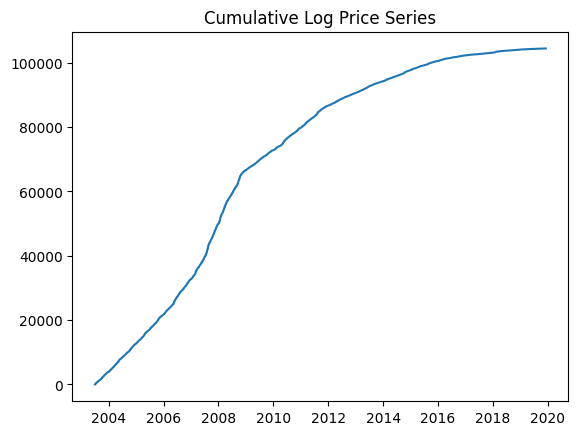

In [ ]:
#calculate the cumulative log price series
df['log_price_cumsum'] = np.log(df['close']).cumsum()
plt.plot(df['log_price_cumsum'])
plt.title('Cumulative Log Price Series')    

In [53]:
#apply FFD and find the minium d value that makes the series stationary

#parameters for FFD
d = 0.0
d_max = 2
step = 0.05
tau = 1e-5
#get a series object from log_price_cumsum
original_series = pd.DataFrame(df['log_price_cumsum'], columns=['log_price_cumsum'])

while d <= d_max:
    series_fd = fracDiff_FFD(original_series, d=d, thres=tau)
    series_fd_col = series_fd.log_price_cumsum.dropna()
    
    #skip if the result of afd is empty
    if len(series_fd_col) == 0:
        # skip to next d
        d += step
        continue
    
    result_adf = adfuller(series_fd_col)
    print(f'ADF Statistic for FFD Y with d={round(d,2)}: {round(result_adf[0],4)} with p-value: {round(result_adf[1],4)}')
    
    if result_adf[1] < 0.05:
        print(f'Minimum d to get a p-val below 5% is {round(d,2)}')
        break
    
    d += step


ADF Statistic for FFD Y with d=0.0: 1.3145 with p-value: 0.9967
ADF Statistic for FFD Y with d=0.05: 1.9065 with p-value: 0.9985
ADF Statistic for FFD Y with d=0.1: 1.7679 with p-value: 0.9983
ADF Statistic for FFD Y with d=0.15: 1.5809 with p-value: 0.9978
ADF Statistic for FFD Y with d=0.2: 1.7395 with p-value: 0.9982
ADF Statistic for FFD Y with d=0.25: 1.6191 with p-value: 0.9979
ADF Statistic for FFD Y with d=0.3: 1.7574 with p-value: 0.9983
ADF Statistic for FFD Y with d=0.35: 2.0034 with p-value: 0.9987
ADF Statistic for FFD Y with d=0.4: 2.2131 with p-value: 0.9989
ADF Statistic for FFD Y with d=0.45: 2.529 with p-value: 0.9991
ADF Statistic for FFD Y with d=0.5: 2.8312 with p-value: 1.0
ADF Statistic for FFD Y with d=0.55: 3.1426 with p-value: 1.0
ADF Statistic for FFD Y with d=0.6: 3.3739 with p-value: 1.0
ADF Statistic for FFD Y with d=0.65: 3.4598 with p-value: 1.0
ADF Statistic for FFD Y with d=0.7: 3.6183 with p-value: 1.0
ADF Statistic for FFD Y with d=0.75: 3.7112 with 

A cumulative series or prices is extremely non-stationary --> FFD is not able to solve the issue

Let's apply it on returns

#### FFD on log prices


Text(0.5, 1.0, 'Log Price Series')

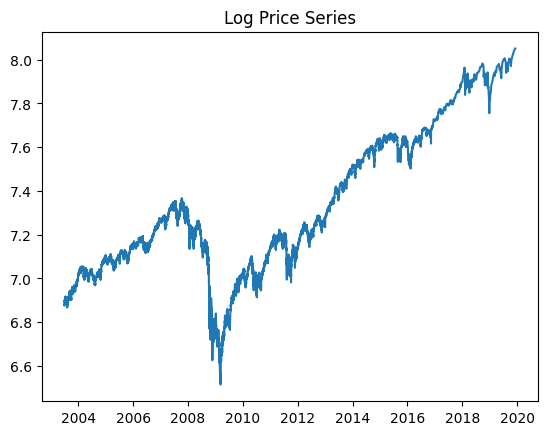

In [54]:
#calculate the cumulative log price series
df['log_price'] = np.log(df['close'])
plt.plot(df['log_price'])
plt.title('Log Price Series')    

In [69]:
#apply FFD and find the minium d value that makes the series stationary

#parameters for FFD
d = 0.0
d_max = 2
step = 0.05
tau = 1e-5
#get a series object from log_price_cumsum
original_series = pd.DataFrame(df['log_price'], columns=['log_price'])

while d <= d_max:
    series_fd = fracDiff_FFD(original_series, d=d, thres=tau)
    series_fd_col = series_fd.log_price.dropna()
    
    #skip if the result of afd is empty
    if len(series_fd_col) == 0:
        # skip to next d
        d += step
        continue
    
    result_adf = adfuller(series_fd_col)
    print(f'ADF Statistic for FFD Y with d={round(d,2)}: {round(result_adf[0],4)} with p-value: {round(result_adf[1],4)}')
    
    if result_adf[1] < 0.05:
        print(f'Minimum d to get a p-val below 5% is {round(d,2)}')
        break
    
    d += step

d_optimal = d


ADF Statistic for FFD Y with d=0.0: 1.2212 with p-value: 0.9961
ADF Statistic for FFD Y with d=0.05: 0.814 with p-value: 0.9919
ADF Statistic for FFD Y with d=0.1: 0.3492 with p-value: 0.9795
ADF Statistic for FFD Y with d=0.15: -0.2082 with p-value: 0.9375
ADF Statistic for FFD Y with d=0.2: -0.8691 with p-value: 0.798
ADF Statistic for FFD Y with d=0.25: -1.5863 with p-value: 0.4905
ADF Statistic for FFD Y with d=0.3: -2.3953 with p-value: 0.1431
ADF Statistic for FFD Y with d=0.35: -3.2389 with p-value: 0.0178
Minimum d to get a p-val below 5% is 0.35


Prices are non-stationary as well (cumulative log price have one extra order of integration --> extremely non stationary) --> FFD is able to stationarize with d = 0.35

Now we can check if memory has been preserved by computing the correlation

In [70]:
print(f'The min d to pass ADF test is {d_optimal}')

The min d to pass ADF test is 0.35


In [71]:
#perform FFD with d_min such that ADF is passed
series_fd = fracDiff_FFD(original_series, d=d_optimal, thres=tau)

In [72]:
#compute the correlation

fd_col = series_fd['log_price'].dropna()
#align original series to the same indices
orig_col = original_series.loc[fd_col.index, 'log_price']
correlation = orig_col.corr(fd_col)

print(f"Correlation between FFD series and original series: {correlation:.4f}")


Correlation between FFD series and original series: 0.8390


A correlation of ~0.84 is not bad at all. This means that fractionally differencing with an order of d = 0.35 makes the series stationary while preserving quite a lot of the information (memory) that would otherwise being lost if fully fractioning.

In [ ]:
correlation_full_frac = df.log_price.corr(df.log_price.diff())

print(f"Correlation between FFD series and original series: {correlation_full_frac:.4f}")

Correlation between FFD series and original series: 0.0321


As you can see when fully fractionind (d=1) the correlation drops almost to zero --> all the stochastic memory is erased!

### NExt